# Registration of markers in self-correction and manual correction frames

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from open3d.pipelines.registration import registration_icp, TransformationEstimationPointToPoint

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Load and plot markers positions

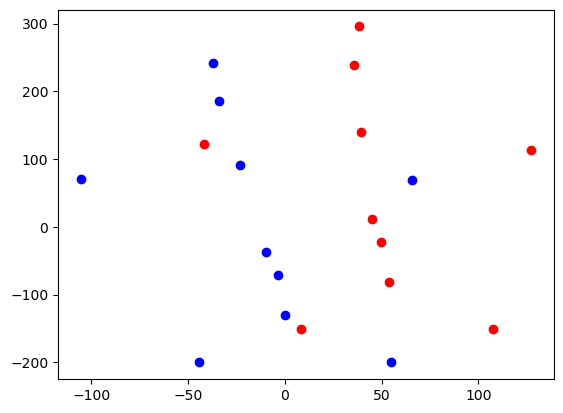

In [2]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

json_corr = open(os.path.join(path, r'Corrected\Prise01\Positions\positions_xyzr.json'))
pos_corr = json.load(json_corr)

json_auto = open(os.path.join(path, r'autocorrection\Prise01\Positions\positions_xyzr.json'))
pos_auto = json.load(json_auto)

x_corr, y_corr, z_corr = [], [], []
x_auto, y_auto, z_auto = [], [], []

for corr, auto in zip(pos_corr.values(), pos_auto.values()):
    x_corr, y_corr, z_corr = [], [], []
    x_auto, y_auto, z_auto = [], [], []
    for c_corr, c_auto in zip(corr.values(), auto.values()):
        x_corr.append(c_corr[0])
        y_corr.append(c_corr[1])
        z_corr.append(c_corr[2])
        x_auto.append(c_auto[0])
        y_auto.append(c_auto[1])
        z_auto.append(c_auto[2])
    
plt.scatter(x_auto, y_auto, c='b')
plt.scatter(x_corr, y_corr, c='r')
plt.show()

ICP-registration function definition and execution with loaded sets of makers

In [3]:
def ICP_registration(source, target):
    pc_target = o3d.geometry.PointCloud()
    pc_target.points = o3d.utility.Vector3dVector(target)
    pc_source = o3d.geometry.PointCloud()
    pc_source.points = o3d.utility.Vector3dVector(source)

    trans_init = np.eye(4)
    reg_p2p = registration_icp(pc_source, pc_target, 300, trans_init, TransformationEstimationPointToPoint())
    pc_source_t = pc_source.transform(reg_p2p.transformation)
    source_trans = np.asarray(pc_source_t.points)

    RMSE = reg_p2p.inlier_rmse

    return source_trans, RMSE

array_corr = np.array([x_corr, y_corr, z_corr]).T
array_auto = np.array([x_auto, y_auto, z_auto]).T

array_corr_t, RMSE = ICP_registration(array_corr, array_auto)

print('RMSE =', np.asarray(RMSE)) #RMSE is the mean distance between paired points after registration


RMSE = 8.0759315053811


Show ICP registration result

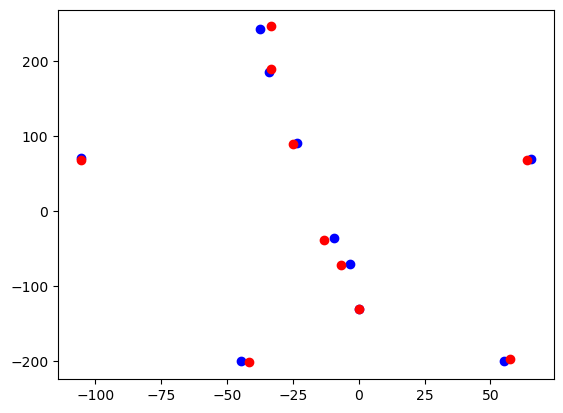

[1451.23915845 1427.09653859 1411.97217666 1427.13149062 1429.59830047
 1432.14747318 1394.17502981 1391.49255156 1423.80271973 1425.03776646]
[1456.70277054 1438.55525825 1406.968416   1415.70654307 1423.42125799
 1430.34889636 1387.75523599 1389.35153078 1433.06424953 1431.81904701]


In [4]:
array_auto = np.asarray(array_auto).T
array_corr = np.asarray(array_corr_t).T

fig, ax1 = plt.subplots()
ax1.scatter(array_auto[0,:], array_auto[1,:], c='b')
ax1.scatter(array_corr[0,:], array_corr[1,:], c='r')
plt.show()

print(array_auto[2])
print(array_corr[2])

Autocorrection 4, Corrected 1 	 RMSE min = 5.3300, frame 26
Autocorrection 4, Corrected 2 	 RMSE min = 6.5905, frame 26
Autocorrection 4, Maximum 1 	 RMSE min = 10.7905, frame 29
Autocorrection 4, Maximum 2 	 RMSE min = 10.7932, frame 29
Autocorrection 4, Minimum 1 	 RMSE min = 13.8421, frame 11
Autocorrection 4, Minimum 2 	 RMSE min = 5.3352, frame 26


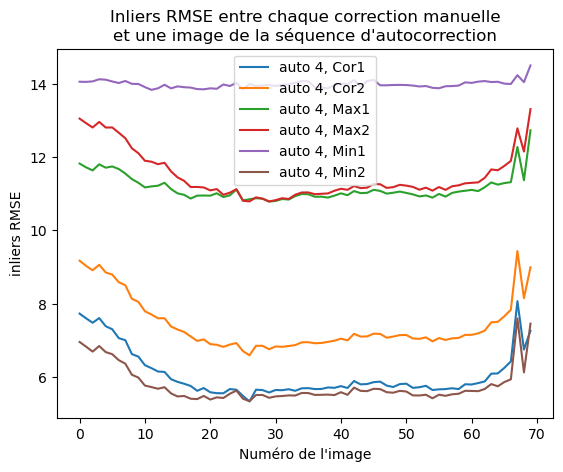

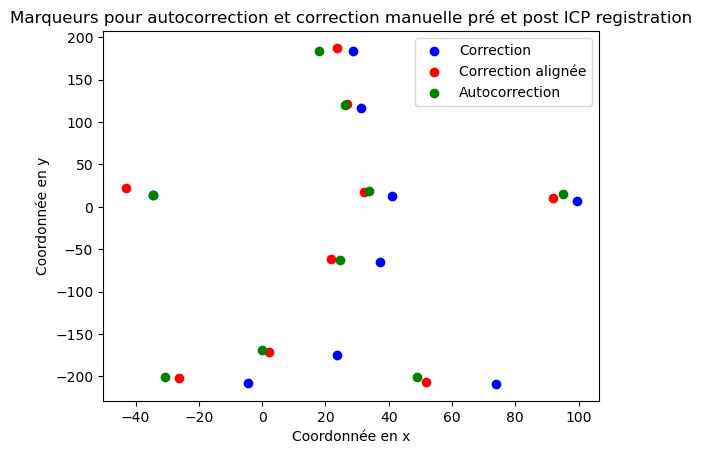

In [11]:
path = r'D:\StageE23\Data\Ete_2023\Participant24'

correction_paths = [r'Corrected\Prise01\Positions\positions_xyzr.json', r'Corrected\Prise02\Positions\positions_xyzr.json',
                    r'Maximum\Prise01\Positions\positions_xyzr.json', r'Maximum\Prise02\Positions\positions_xyzr.json',
                    r'Minimum\Prise01\Positions\positions_xyzr.json', r'Minimum\Prise02\Positions\positions_xyzr.json']

# Rassemble les dictionnaires des positions des marqueurs sur frames corrigés avec type de correction + n° prise comme clé
corrected_pos = {}
for corr_path in correction_paths:
    try:
        file_corr = open(os.path.join(path, corr_path))
        pos_corr = json.load(file_corr)
        if not str(corr_path[:-38]) in corrected_pos:
            corrected_pos.update({str(corr_path[:-38] + ' ' + corr_path[-31:-30]) : pos_corr})
    except FileNotFoundError:
        continue

# Rassemble les dictionnaires des positions des marqueurs sur autocorrection avec n° prise comme clé
auto_pos = {}
for auto_path in os.listdir(path + '/autocorrection/')[3:4]:
    try:
        json_auto = open(path + '/autocorrection/' + auto_path + '/Positions/positions_xyzr.json')
        pos_auto = json.load(json_auto)
        auto_pos.update({auto_path[-1]: pos_auto})
    except FileNotFoundError:
        continue

# Compute RMSE for ICPregistration between positions of markers autocorrection and manual correction frames
# Boucle sur les séquences d'autocorrection
answer = {}
for i, pos_auto in auto_pos.items():
    # Boucle sur les frames avec correction appliquée (straight, max, min)
    for type_corr, pos_corr in corrected_pos.items():
        array_corr = [[c_corr[0], c_corr[1], c_corr[2]] for c_corr in list(pos_corr.values())[len(pos_corr.values())//2].values()] # sélection du frame central de la séquence
        array_corr = np.asarray(array_corr)
        # Boucle sur les frames d'autocorrection
        arrays_auto = []
        RMSEs = []
        for auto in pos_auto.values():
            array_auto = []
            for c_auto in auto.values():
                array_auto.append([c_auto[0], c_auto[1], c_auto[2]])

            a = sorted(array_auto, key=lambda tup: tup[0])[0]
            b = sorted(array_corr, key=lambda tup: tup[0])[0]

            dist = np.subtract(a, b)
            array_corr = array_corr + dist
            
            array_corr_t, RMSE = ICP_registration(array_corr, array_auto)
            RMSEs.append(RMSE)
        answer.update({f'Autocorrection {i}, {type_corr}': f'RMSE min = {min(RMSEs):.4f}, frame {RMSEs.index(min(RMSEs))}'})
        plt.plot(RMSEs, label=f'auto {i}, {type_corr[:3]+type_corr[-1]}')
plt.legend()
plt.title("Inliers RMSE entre chaque correction manuelle\net une image de la séquence d'autocorrection")
plt.xlabel("Numéro de l'image")
plt.ylabel('inliers RMSE')

plt.figure()
array_auto = np.asarray(array_auto)
plt.scatter(array_corr[:,0], array_corr[:,1], color='b', label='Correction')
plt.scatter(array_corr_t[:,0], array_corr_t[:,1], color='r', label='Correction alignée')
plt.scatter(array_auto[:,0], array_auto[:,1], color='g', label='Autocorrection')
plt.legend()
plt.title("Marqueurs pour autocorrection et correction manuelle pré et post ICP registration")
plt.xlabel('Coordonnée en x')
plt.ylabel('Coordonnée en y')

for key, vals in answer.items():
    print(key, '\t', vals)

